# Import libraries

In [ ]:
#!pip install music21

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Applied\ DL\ Music/

/content/drive/.shortcut-targets-by-id/1WiLGkdpFT7wl_snghM9azz5CzfomSCrF/Applied DL Music


In [ ]:
import music21
from IPython.display import Image, Audio
import os
import json
import numpy as np
import tensorflow as tf
import pprint
import IPython

In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

installing lilypond...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libauthen-sasl-perl libcupsfilters1 libcupsimage2 libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl libgs9
  libgs9-common libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libijs-0.35 libio-html-perl libio-socket-ssl-perl
  libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2
  libtext-unidecode-perl libtimedate-perl libtry-tiny-perl liburi-perl
  libwww-perl libwww-robotrules-perl libxml-libxml-perl

# Music21 setup

In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  wav_filename = os.path.join(os.path.join(filename)[:-4] + ".wav")
  !fluidsynth -ni font.sf2 $filename -F $wav_filename -r 16000
  display(Audio(wav_filename))

# Preprocess dataset


```
https://github.com/musikalkemist/generating-melodies-with-rnn-lstm/blob/master/3%20-%20Preprocessing%20dataset%20for%20melody%20generation%20pt%201/code/preprocess.py
```





## Raw preprocessing

In [ ]:
# durations in quarter length
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

SAVE_DIR = "./encoded_datasets/test_dataset/"
SINGLE_FILE_DATASET_OUTPUT = "./encoded_datasets/single_file_test_dataset.txt"
MAPPINGS_FILE = "./encoded_datasets/mappings.txt"
SEQUENCE_LENGTH = 64
SAVE_MODEL_PATH = "./encoded_datasets/vae_model.h5"
OUTPUT_MIDI_PATH = "./encoded_datasets/"

In [ ]:
def hasAcceptableDurations(song, acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [ ]:
def transpose(song):
    # Estimate key using music21
    key = song.analyze("key")

    # Get interval for transposition
    if key.mode == "major":
        interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("C"))
    if key.mode == "minor":
        interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)
    return transposed_song

In [ ]:
def encodeSong(song, time_step=0.25):
    encoded_song = []
    for event in song.flat.notesAndRests:
        # Handle notes
        symbol = None
        if isinstance(event, music21.note.Note):
            symbol = event.pitch.midi
        # Handle rests
        elif isinstance(event, music21.note.Rest):
            symbol = "r"
        
        if symbol:

          steps = int(event.duration.quarterLength/time_step)
          for step in range(steps):
              # If it's the first time we see a note/rest, we encode it.
              # Otherwise, it means we're carrying the same symbol a new time step
              if step == 0:
                  encoded_song.append(symbol)
              else:
                  encoded_song.append("_")
        
        else:
          return None

    # Cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song

In [ ]:
def preprocess():
    # Load songs
    paths = music21.corpus.getComposer('bach')
    print("Loaded {} songs".format(len(paths)))

    for i, path in enumerate(paths):
        print('Processing song {}'.format(i))
        song = music21.corpus.parse(path)
        # Remove songs which have non acceptable durations
        if not hasAcceptableDurations(song, ACCEPTABLE_DURATIONS):
            print('- Not acceptable durations')
            continue
        
        # Transpose song to Cmaj/Amin
        #song = transpose(song)

        # Encode song
        encoded_song= encodeSong(song)

        if encoded_song:

          # Save encoded song
          save_path = os.path.join(SAVE_DIR, str(i) + ".txt")
          with open(save_path, "w") as fp:
              fp.write(encoded_song)
              print('- Song saved')

In [ ]:
#preprocess()

## Generate mappings

In [ ]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

In [ ]:
def createSingleFileDataset(dataset_path, output_path, sequence_length):
    new_song_delimiter = "/ " * sequence_length
    dataset = ""

    # Load songs and add delimiters
    for encoded_song_filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, encoded_song_filename)
        song = load(file_path)
        dataset = dataset + song + " " + new_song_delimiter

    # Remove empty space at the end
    dataset = dataset[:-1]

    # Save our final single file dataset
    with open(output_path, "w") as fp:
        fp.write(dataset)

    return dataset

In [ ]:
raw_dataset = createSingleFileDataset(SAVE_DIR, SINGLE_FILE_DATASET_OUTPUT, SEQUENCE_LENGTH)
len(raw_dataset)

954798

In [ ]:
def createMapping(raw_dataset, mapping_path):
    mappings = {}

    # Identify vocabulary
    raw_dataset = raw_dataset.split()
    vocabulary = list(set(raw_dataset))

    # Create mapping
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    # Save vocabulary to a json file
    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)

In [ ]:
createMapping(raw_dataset, MAPPINGS_FILE)

## Create sequences

In [ ]:
def datasetToNumerical(raw_dataset, mappings_file):
    numerical_dataset = []

    # Load mappings
    with open(mappings_file, 'r') as fp:
        mappings = json.load(fp)
    
    raw_dataset = raw_dataset.split()

    # Map symbol to numerical value
    for symbol in raw_dataset:
        numerical_dataset.append(mappings[symbol])
    
    return numerical_dataset

In [ ]:
numerical_dataset = datasetToNumerical(raw_dataset, MAPPINGS_FILE)

In [ ]:
def generateTrainingSequence(numerical_dataset, seq_length):
    # One-hot encode the sequences
    vocabulary_size = len(set(numerical_dataset))
    ohe_numerical_dataset = tf.keras.utils.to_categorical(numerical_dataset, num_classes=vocabulary_size)

    X = []
    y = []

    # Generate training sequences
    num_sequences = len(ohe_numerical_dataset) - seq_length
    for i in range(num_sequences):
        X.append(ohe_numerical_dataset[i: i + seq_length])
        y.append(ohe_numerical_dataset[i + seq_length])

    # Inputs size: (# of sequences, sequence length, vocabulary size)
    X = np.array(X)
    y = np.array(y)

    return X, y


In [ ]:
X, y = generateTrainingSequence(numerical_dataset, SEQUENCE_LENGTH)

## Explore dataset

In [ ]:
X.shape, y.shape

((425252, 64, 55), (425252, 55))

# Training

In [ ]:
import keras
from keras import Model
from keras import layers
from keras.layers import LSTM, Bidirectional, Dense, Input, Reshape, GRU
from tensorflow.keras.backend import random_normal

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(Model):
  """VAE model class."""

  def __init__(self, latent_space=128, sequence_length=64, vocabulary_size=55):
    """Init layers.

    We need a layer to process the time serie, a projector on the latent space and a sampling layer with respecting to the latent space.
    """
    super().__init__()

    input = Input(shape=(sequence_length, vocabulary_size))
    x = Bidirectional(LSTM(256, return_sequences=True))(input)
    x = Bidirectional(LSTM(256, return_sequences=False))(x)
    x = Dense(256)(x)
    z_mean = Dense(latent_space)(x)
    z_log_var = Dense(latent_space)(x)
    z = Sampling()([z_mean, z_log_var])
    x = GRU(latent_space, return_sequences=True)(input, initial_state=z)
    x = LSTM(256, return_sequences=False)(x)
    softmax = Dense(vocabulary_size, activation='softmax')(x)

    self.encoder = Model(input, [z_mean, z_log_var, z], name='encoder')
    self.decoder = Model([input, z], softmax, name='decoder')

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.pitch_predicted_loss_tracker = keras.metrics.Mean(
        name="pitch_predicted_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    self.accuracy = tf.keras.metrics.Accuracy()
  
  def summary(self):

    self.encoder.summary()
    self.decoder.summary()
  
  def call(self, x):

    _, _, z = self.encoder(x)
    x = self.decoder([x, z])

    return x

  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.pitch_predicted_loss_tracker,
          self.kl_loss_tracker,
          self.accuracy
      ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      seq, pitch = data
      z_mean, z_log_var, z = self.encoder(seq)
      pitch_predicted = self.decoder([seq, z])
      pitch_predicted_loss = keras.losses.categorical_crossentropy(pitch, pitch_predicted)
      # trying to be as close as possible to the centred reduced normal distribution
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = pitch_predicted_loss + kl_loss 
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.pitch_predicted_loss_tracker.update_state(pitch_predicted_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.accuracy.update_state(tf.argmax(pitch, axis=-1), tf.argmax(pitch_predicted, axis=-1))
    return {
        "loss": self.total_loss_tracker.result(),
        "pitch_predicted_loss": self.pitch_predicted_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
        'accuracy': self.accuracy.result()
    }


In [ ]:
my_model = VAE()
my_model.compile(optimizer='adam')
my_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 55)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 64, 512)      638976      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 512)         1574912     ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          131328      ['bidirectional_1[0][0]']  

In [ ]:
history = my_model.fit(X, y, epochs=25, batch_size=32)

Epoch 1/25
13290/13290 [==============================] - 481s 35ms/step - loss: 1.0845 - pitch_predicted_loss: 0.9430 - kl_loss: 2.7472e-04 - accuracy: 0.7649
Epoch 2/25
13290/13290 [==============================] - 473s 36ms/step - loss: 0.7293 - pitch_predicted_loss: 0.6972 - kl_loss: 1.3711e-04 - accuracy: 0.8048
Epoch 3/25
13290/13290 [==============================] - 473s 36ms/step - loss: 0.6083 - pitch_predicted_loss: 0.6009 - kl_loss: 1.4251e-04 - accuracy: 0.8266
Epoch 4/25
13290/13290 [==============================] - 473s 36ms/step - loss: 0.5474 - pitch_predicted_loss: 0.5461 - kl_loss: 1.7663e-04 - accuracy: 0.8391
Epoch 5/25
13290/13290 [==============================] - 473s 36ms/step - loss: 0.5026 - pitch_predicted_loss: 0.5069 - kl_loss: 2.1853e-04 - accuracy: 0.8484
Epoch 6/25
13290/13290 [==============================] - 473s 36ms/step - loss: 0.4720 - pitch_predicted_loss: 0.4772 - kl_loss: 2.8433e-04 - accuracy: 0.8551
Epoch 7/25
13290/13290 [================

In [ ]:
my_model.save_weights(SAVE_MODEL_PATH)

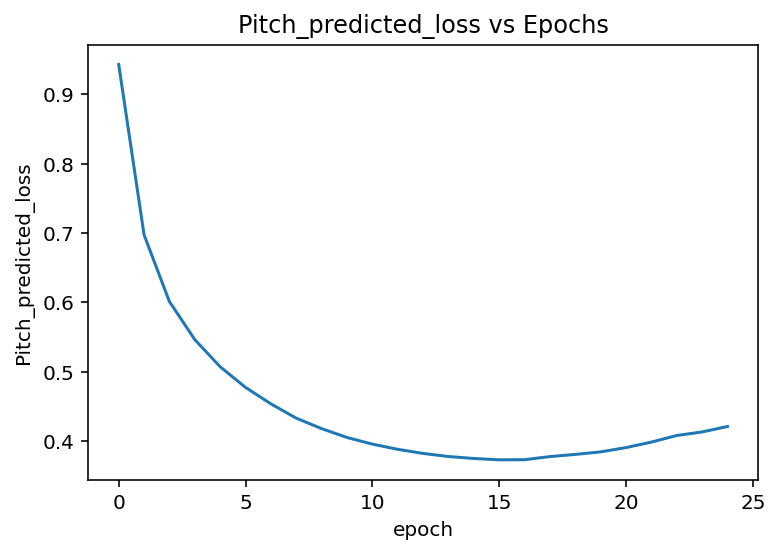

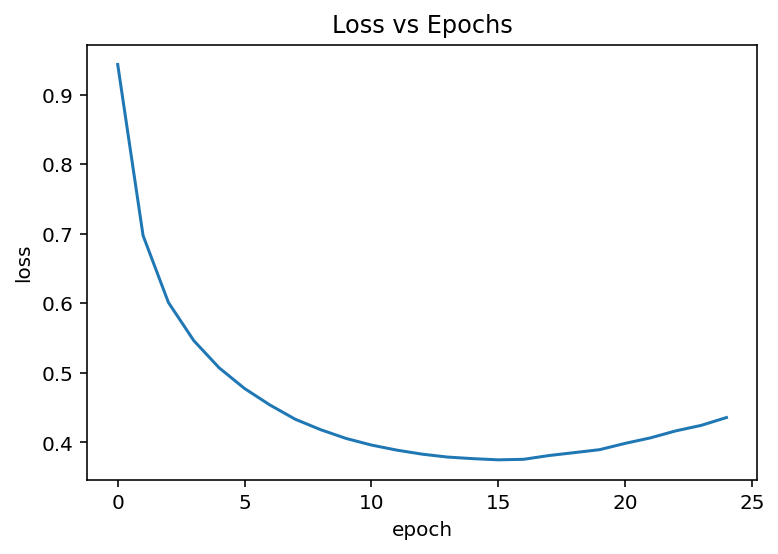

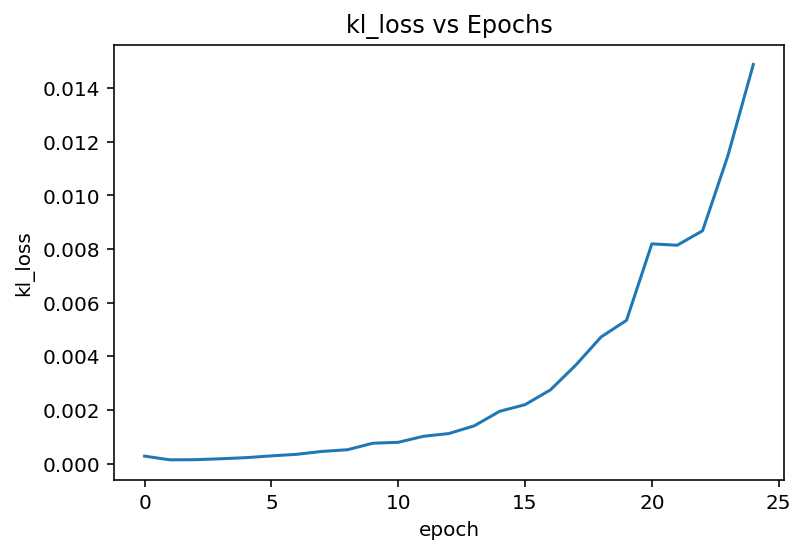

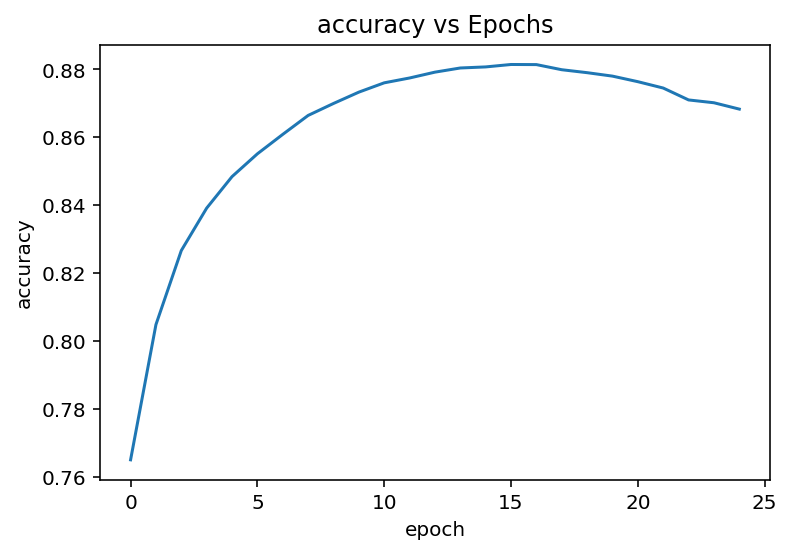

In [ ]:
import matplotlib.pyplot as plt

plt.title('Pitch_predicted_loss vs Epochs')
plt.plot(history.history['pitch_predicted_loss'])
plt.ylabel('Pitch_predicted_loss')
plt.xlabel('epoch')
plt.show()

plt.title('Loss vs Epochs')
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.title('kl_loss vs Epochs')
plt.plot(history.history['kl_loss'])
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.show()

plt.title('accuracy vs Epochs')
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Generate melody

In [ ]:
model = VAE()
model.built = True
model.load_weights(SAVE_MODEL_PATH)

with open(MAPPINGS_FILE, "r") as fp:
    mappings = json.load(fp)

start_symbols = ["/"] * SEQUENCE_LENGTH

In [ ]:
def sampleWithTemperature(probabilities, temperature):
    predictions = np.log(probabilities) / temperature
    probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilities)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilities)

    return index

In [ ]:
def generateMelody(seed, nb_steps, max_seq_length, temperature):
    np.random.seed(10)
    
    seed = seed.split()
    melody = seed
    seed = start_symbols + seed

    # Map seed to numerical values
    seed = [mappings[symbol] for symbol in seed]

    for _ in range(nb_steps):
        # Limit the seed to max_seq_length
        seed = seed[-max_seq_length:]

        # One-hot encode the seed
        ohe_seed = tf.keras.utils.to_categorical(seed, num_classes=len(mappings))
        ohe_seed = ohe_seed[np.newaxis, ...]

        # Predict the next note
        probabilities = model.predict(ohe_seed)[0] 

        # Sample from probabilities
        note = sampleWithTemperature(probabilities, temperature)

        # Update seed
        seed.append(note)

        output_symbol = [k for k, v in mappings.items() if v == note][0]

        # Check whether we are at the end of the melody
        if output_symbol == "/":
            break
        
        # Update melody
        melody.append(output_symbol)
    
    return melody

In [ ]:
def saveMelody(melody, path, step_duration=0.25, format="midi", file_name="mel.mid"):
    # Create a music21 stream
    stream = music21.stream.Stream()

    start_symbol = None
    step_counter = 1

    # parse all the symbols in the melody and create note/rest objects
    for i, symbol in enumerate(melody):

        # handle case in which we have a note/rest
        if symbol != "_" or i + 1 == len(melody):

            # ensure we're dealing with note/rest beyond the first one
            if start_symbol is not None:

                quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                # handle rest
                if start_symbol == "r":
                    music21_event = music21.note.Rest(quarterLength=quarter_length_duration)

                # handle note
                else:
                    music21_event = music21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                stream.append(music21_event)

                # reset the step counter
                step_counter = 1

            start_symbol = symbol

        # handle case in which we have a prolongation sign "_"
        else:
            step_counter += 1

    # write the music21 stream to a midi file
    stream.write(format, os.path.join(path, file_name))
    return stream

In [ ]:
seed = "67 _ _ _ _ _ 65 _ 64 _ 62 _ 60 _ _ _"
#seed = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"


# Temperature : between 0 and 1
# 0 : uniform sampling from probabilities
# 1 : argmax
temperature = 0.8

melody = generateMelody(seed, 500, SEQUENCE_LENGTH, temperature)

In [ ]:
final_melody = saveMelody(melody, OUTPUT_MIDI_PATH)
print(melody)

['67', '_', '_', '_', '_', '_', '65', '_', '64', '_', '62', '_', '60', '_', '_', '_', '_', '_', '_', '_', '60', '_', '_', '_', '62', '_', '_', '_', '53', '_', '_', '_', '52', '_', '65', '_', '_', '_', '60', '_', '57', '_', '_', '_', '45', '_', '62', '_', '47', '_', '64', '_', '_', '_', '60', '_', '_', '_', '57', '_', '_', '_', '45', '_', '_', '_', '67', '_', '_', '_', '64', '_', '_', '_', '60', '_', '_', '_', '48', '_', '_', '_', '65', '_', '_', '_', '62', '_', '_', '_', '57', '_', '_', '_', '50', '_', '_', '_', '67', '_', '_', '_', '62', '_', '_', '_', '55', '_', '_', '_', '43', '_', '_', '_', '64', '_', '_', '_', '_', '_', '_', '_', '60', '_', '_', '_', '_', '_', '_', '_', '55', '_', '_', '_', '_', '_', '_', '_', '48', '_', '_', '_', '_', '_', '_', '_', '69', '_', '_', '_', '60', '_', '_', '_', '57', '_', '_', '_', '53', '_', '52', '_', '69', '_', '_', '_', '65', '_', '_', '_', '62', '_', '_', '_', '50', '_', '48', '_', '69', '_', '_', '_', '65', '_', '_', '_', '62', '_', '_', '_', '

In [ ]:
show(final_melody)
play(final_melody)

Output hidden; open in https://colab.research.google.com to view.